<a href="https://colab.research.google.com/github/PotatoSpudowski/CactiNet/blob/master/Visualizing_CactiNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-.git

fatal: destination path 'A-journey-into-Convolutional-Neural-Network-visualization-' already exists and is not an empty directory.


In [2]:
cd A-journey-into-Convolutional-Neural-Network-visualization-/

/content/A-journey-into-Convolutional-Neural-Network-visualization-


In [0]:
import math
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchsummary import summary
from torchvision.models import *
from visualisation.core.utils import device
from visualisation.core.utils import device 
from visualisation.core.utils import image_net_postprocessing

from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
from visualisation.core import *
from visualisation.core.utils import image_net_preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

##Defining the model

For more info related to the model check my other notebook https://github.com/PotatoSpudowski/CactiNet/blob/master/Building_EfficientNet_model_using_Pytorch.ipynb

In [0]:
class Swish(nn.Module):
    """
    Activation function designed to kick ReLU's @$$
    """
    def forward(self, x):
        return x * torch.sigmoid(x)

class Conv2D_with_same_padding(nn.Conv2d):
    """
    Conv2d layer with padding implemented in a way such that size of 
    the input features and the output features remain same.
    """
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, dilation=1, groups=1, bias=True, padding_mode="zeros"):
        super().__init__(in_ch, out_ch, kernel_size, stride, 0, dilation, groups, bias, padding_mode)

    def get_odd_padding(self, in_ch, weight, stride, dilation):
        filter_row =  (weight - 1) * dilation + 1
        out_rows = (in_ch + stride - 1) // stride
        padding = max(0, (out_rows - 1) * stride + filter_row - in_ch)
        padding_val= max(0, (out_rows - 1) * stride + (weight - 1) * dilation + 1 - in_ch)
        odd = (padding_val % 2 != 0)
        return padding_val, odd

    def forward(self, x):
        padding_row, row_odd = self.get_odd_padding(x.shape[2], self.weight.shape[2], self.stride[0], self.dilation[0])
        padding_collumn, collumn_odd = self.get_odd_padding(x.shape[3], self.weight.shape[3], self.stride[1], self.dilation[1])

        if row_odd or collumn_odd:
            x = F.pad(x, [0, int(collumn_odd), 0, int(row_odd)])
        
        return F.conv2d(x, self.weight, self.bias, self.stride,
                        padding = (padding_row // 2, padding_collumn //2),
                        dilation = self.dilation,
                        groups=self.groups)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

class SqueezeExcitationModule(nn.Module):
    def __init__(self, in_ch, squeeze_ch):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_ch, squeeze_ch, kernel_size=1, stride=1, padding=0, bias=True),
            Swish(),
            nn.Conv2d(squeeze_ch, in_ch, kernel_size=1, stride=1, padding=0, bias=True)
        )

    def forward(self, x):
        return x * torch.sigmoid(self.se(x))

class DropConnections(nn.Module):
    """
    Rndomly disables individual weights
    """
    def __init__(self, ratio):
        super().__init__()
        self.ratio = 1.0 - ratio

    def forward(self, x):
        if not self.training:
            return x

        ran_tensor = self.ratio
        ran_tens += torch.rand([x.shape[0], 1, 1, 1], dtype=torch.float, device=x.device)
        ran_tensor.requires_grad_(False)
        return x / self.ratio * ran_tensor.floor()

def Conv_BatchNorm_Activation(in_ch, out_ch, kernel_size, stride=1, groups=1, bias=True, eps=1e-3, momentum=0.01):
    return nn.Sequential(
        Conv2D_with_same_padding(in_ch, out_ch, kernel_size, stride, groups=groups, bias=bias),
        nn.BatchNorm2d(out_ch, eps, momentum),
        Swish()
    )

class MBConv(nn.Module):
    def __init__(self, in_ch, out_ch, expand, kernel_size, stride, skip, se_ratio, dc_ratio=0.2):
        super().__init__()
        mid = in_ch * expand
        if expand != 0:
            self.expand_conv = Conv_BatchNorm_Activation(in_ch, mid, kernel_size=1, bias = False)
        else:
            nn.Identity()

        self.depth_wise_conv = Conv_BatchNorm_Activation(mid, mid, kernel_size=kernel_size, stride=stride, groups=mid, bias=False)

        if se_ratio > 0:
            self.se = SqueezeExcitationModule(mid, int(in_ch * se_ratio)) 
        else:
            nn.Identity()

        self.project_conv = nn.Sequential(
            Conv2D_with_same_padding(mid, out_ch, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_ch, 1e-3, 0.01)
        )

        self.skip = skip and (stride == 1) and (in_ch == out_ch)

        self.dropconnect = nn.Identity()

    def forward(self, x):
        expand = self.expand_conv(x)
        x1 = self.depth_wise_conv(expand)
        x1 = self.se(x1)
        x1 = self.project_conv(x1)
        if self.skip:
            x1 = self.dropconnect(x1)
            x1 = x1 + x
        return x1

class MBBlock(nn.Module):
    def __init__(self, in_ch, out_ch, expand, kernel, stride, num_repeat, skip, se_ratio, drop_connect_ratio=0.2):
        super().__init__()
        layers = [
            MBConv(in_ch, out_ch, expand, kernel, stride, skip, se_ratio, drop_connect_ratio)
        ]

        for i in range(1, num_repeat):
            layers.append(MBConv(out_ch, out_ch, expand, kernel, 1, skip, se_ratio, drop_connect_ratio))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return  self.layers(x)

class CactiNet(nn.Module):
    def __init__(self, width_coeff=1, depth_coeff=1, depth_div=8, min_depth=None, dropout_rate=0.2, drop_connect_rate=0.2, num_classes=1):
        super().__init__()
        min_depth = min_depth or depth_div

        def renew_ch(x):
            if not width_coeff:
                return x

            x *= width_coeff
            new_x = max(min_depth, int(x + depth_div / 2) // depth_div * depth_div)
            if new_x < 0.9 * x:
                new_x += depth_div
            return int(new_x)

        def renew_repeat(x):
            return int(math.ceil(x * depth_coeff))

        self.stem = Conv_BatchNorm_Activation(3, renew_ch(32), kernel_size=3, stride=2, bias=False)

        self.blocks = nn.Sequential(
            MBBlock(renew_ch(32), renew_ch(18), 1, 3, 1, renew_repeat(1), True, 0.25, drop_connect_rate),
            MBBlock(renew_ch(18), renew_ch(28), 6, 3, 2, renew_repeat(2), True, 0.25, drop_connect_rate),
            MBBlock(renew_ch(28), renew_ch(46), 6, 5, 2, renew_repeat(2), True, 0.25, drop_connect_rate),
            MBBlock(renew_ch(46), renew_ch(80), 6, 3, 2, renew_repeat(3), True, 0.25, drop_connect_rate),
            MBBlock(renew_ch(80), renew_ch(122), 6, 5, 1, renew_repeat(3), True, 0.25, drop_connect_rate),
            MBBlock(renew_ch(122), renew_ch(192), 6, 5, 2, renew_repeat(4), True, 0.25, drop_connect_rate),
            MBBlock(renew_ch(192), renew_ch(320), 6, 3, 1, renew_repeat(1), True, 0.25, drop_connect_rate)
        )

        self.head = nn.Sequential(
            *Conv_BatchNorm_Activation(renew_ch(320), renew_ch(1280), kernel_size=1, bias=False),
            nn.AdaptiveAvgPool2d(1),
            nn.Dropout2d(dropout_rate, True),
            Flatten(),
            nn.Linear(renew_ch(1280), num_classes)
        )

    def forward(self, inputs):
        stem = self.stem(inputs)
        x = self.blocks(stem)
        head = self.head(x)
        return head

In [0]:
model = CactiNet()
model = model.to('cuda')

##Geting data and training the model

In [0]:
from google.colab import files
# files.upload()
#Upload the kaggle.json file here

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c aerial-cactus-identification

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
!unzip train.zip
!unzip test.zip
!ls

Archive:  train.zip
replace train/008bd3d84a1145e154409c124de7cee9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  test.zip
replace test/000940378805c44108d287872b2f04ce.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  imaganet2human.txt   medium	       README.md	       train
 images		      models	       resources	       train.csv
'kaggle (1).json'     notebook.ipynb   sample_submission.csv   train.zip
 kaggle.json	      notebook.pdf     test		       utils.py
 LICENSE	      __pycache__      test.zip		       visualisation


In [0]:
train = './train'
test = './test'

train_labels =  pd.read_csv('./train.csv')

class Data(Dataset):
    def __init__(self, df, data_dir, transform):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name = self.df.id[index]
        label = self.df.has_cactus[index]

        img_path = os.path.join(self.data_dir, img_name)
        img = mpimg.imread(img_path)
        img = self.transform(img)
        return img, label

data_transf = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
train_data = Data(df = train_labels, data_dir = train, transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size = 64)

for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.BCELoss()

In [12]:
%%time
loss_log = []
val_loss_log = []
n_epochs = 5

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 50)

    model.train()
    for step, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        target = target.float()

        optimizer.zero_grad()
        output = model(data)

        m = nn.Sigmoid()
        loss = loss_func(m(output), target)
        loss.backward()

        optimizer.step()

        if step % 10 == 0:
            loss_log.append(loss.item())      

    print('Epoch: {} - Loss: {}'.format(epoch+1, loss.item()))

Epoch 0/9
--------------------------------------------------
Epoch: 1 - Loss: 0.23225781321525574
Epoch 1/9
--------------------------------------------------
Epoch: 2 - Loss: 0.16275851428508759
Epoch 2/9
--------------------------------------------------
Epoch: 3 - Loss: 0.07408863306045532
Epoch 3/9
--------------------------------------------------
Epoch: 4 - Loss: 0.05268172174692154
Epoch 4/9
--------------------------------------------------
Epoch: 5 - Loss: 0.0037877168506383896
Epoch 5/9
--------------------------------------------------
Epoch: 6 - Loss: 0.005118530709296465
Epoch 6/9
--------------------------------------------------
Epoch: 7 - Loss: 0.0005394251784309745
Epoch 7/9
--------------------------------------------------
Epoch: 8 - Loss: 0.00025310972705483437
Epoch 8/9
--------------------------------------------------
Epoch: 9 - Loss: 0.00047301180893555284
Epoch 9/9
--------------------------------------------------
Epoch: 10 - Loss: 7.567722059320658e-05
CPU ti

In [0]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from utils import *

from visualisation.core.utils import device 
from PIL import Image

In [0]:
image_paths = glob.glob('./test/*.*')
image_paths = image_paths[:3]

In [0]:
images = list(map(lambda x: Image.open(x), image_paths))

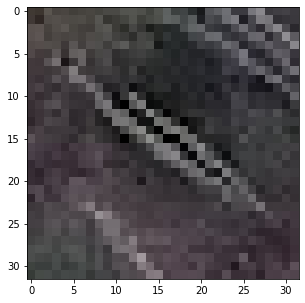

In [42]:
plt.rcParams["figure.figsize"]= 5,5
plt.imshow(images[0])

In [0]:
inputs  = [Compose([Resize((224,224)), ToTensor(), image_net_preprocessing])(x).unsqueeze(0) for x in images]

In [0]:
inputs = [i.to('cuda') for i in inputs]

In [0]:
#clean gpu cache
def free(modules):
    for m in modules:
        del m
    torch.cuda.empty_cache()

In [47]:
model_traced = module2traced(model, inputs[0])
model_traced

[Conv2D_with_same_padding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False),
 BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
 Swish(),
 Conv2D_with_same_padding(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False),
 BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
 Swish(),
 Conv2D_with_same_padding(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False),
 BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
 Swish(),
 AdaptiveAvgPool2d(output_size=1),
 Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1)),
 Swish(),
 Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1)),
 Conv2D_with_same_padding(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False),
 BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
 Conv2D_with_same_padding(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False),
 BatchNorm2d(144, eps=0.001, momentum=0.01, affine=True, track_running

In [0]:
vis = Weights(model, device)

###Visualizing the weights of the first conv layer

torch.Size([1, 112, 112])


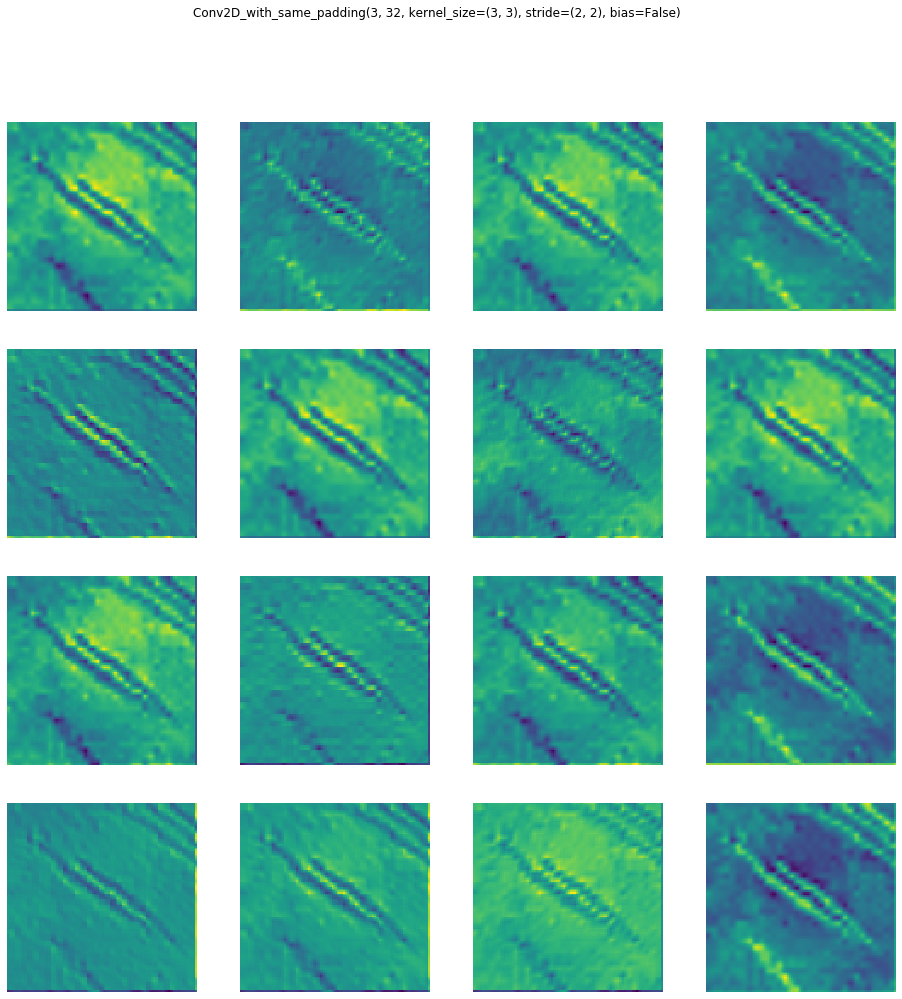

In [49]:
first_layer = model_traced[0]

plt.rcParams["figure.figsize"]= 16,16

run_vis_plot(vis, inputs[0], first_layer, ncols=4, nrows=4)

##Saliency Map
The idea proposed by [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034) is to back-prop the output of the network with respect to a target class until the input and plot the computed gradient. This will highligh the part of the image responsible for that class.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


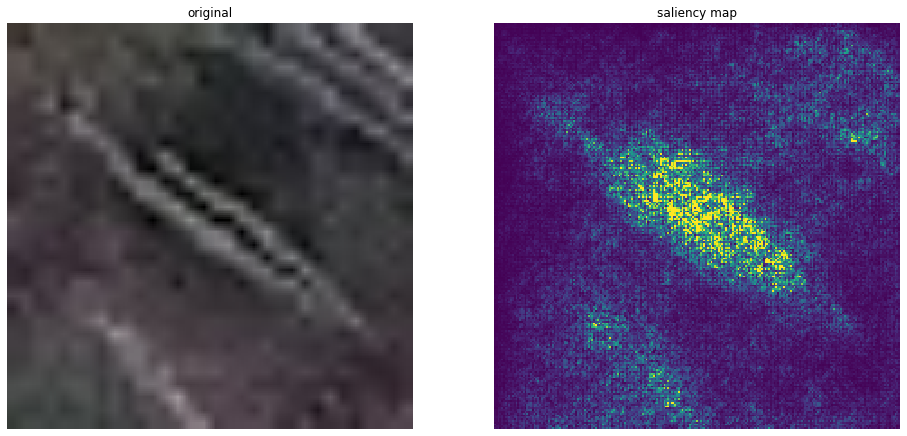

In [28]:
vis = SaliencyMap(model, device)

out, info = vis(inputs[0], 
          first_layer)

subplot([image_net_postprocessing(inputs[0].squeeze().cpu()), out], 
        rows_titles=['original', 'saliency map'],
        parse=tensor2img, 
        nrows=1, ncols=2)
